# The Big Overview

Here, we'll look at the behavior of a simple one-node perceptron on a couple of different data sets. Then, we'll make a tiny network in Pytorch and compare it to the perceptron.

In [30]:
# We'll be needing these...
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline


# Make some dataset builders: linearly separable, center-surround, xor, spirals


## Start with a helper function to plot the data


In [31]:
def plot_data(data,labels):
  """A helper function to plot our data sets 
  
  PARAMETERS
  ----------
  data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows
  
  labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
            element. The jth element is the label of the jth example"""
  # plot the data
  pos_idx = np.where(labels==1)
  neg_idx = np.where(labels==-1)
  plt.plot(data.T[0,pos_idx], data.T[1,pos_idx],'r^', data.T[0,neg_idx], data.T[1,neg_idx], 'bo')
  plt.axis('equal')



## Data Set 1: Linearly separable

In [ ]:
def  make_linearly_separable_data(examples_per_class, distance_between_means):
  """create a 2-dimensional set of points, where half the points are drawn from
  one Gaussian and the other half are drawn from a different Gaussian 
  
  PARAMETERS
  ----------
  examples_per_class      An integer determining how much data we'll generate

  distance_between_means  Distance between the means of the two Gaussians.

  RETURNS
  -------
  data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows
  
  labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
            element. The jth element is the label of the jth example"""

  mean = [0,0]
  cov = [[1,0],[0,1]] 

  # negative class -1
  negData = np.random.multivariate_normal(mean,cov,examples_per_class)

  # positive class 1
  posData = np.random.multivariate_normal(mean,cov,examples_per_class)
  posData += distance_between_means

  # make the labels
  negL = np.ones(examples_per_class) * -1  
  posL = np.ones(examples_per_class)

  # wrap it up and ship it out!
  data = np.concatenate([posData, negData])
  labels = np.concatenate([posL,negL])

  return data, labels

# Test it out
data, labels = make_linearly_separable_data(100, 3)
plot_data(data, labels)


## Data set 2: XOR

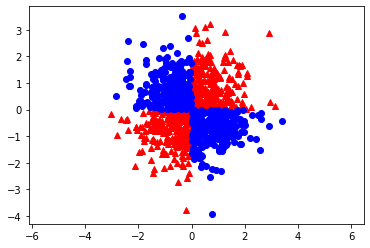

In [33]:
def  make_XOR_data(examples_per_class):
  """create a 2-dimensional set of points in the XOR pattern. Things in the 
  upper right and lower left quadrant are class 1. Things in the other two
  quadrants are class -1. 
  
  PARAMETERS
  ----------
  examples_per_class      An integer determining how much data we'll generate

  RETURNS
  -------
  data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows
  
  labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
            element. The jth element is the label of the jth example"""

  mean = [0,0]
  cov = [[1,0],[0,1]] 

  # make a circular unit Gaussian and sample from it
  data = np.random.multivariate_normal(mean,cov,examples_per_class*2)

  x = data.T[0]
  y = data.T[1]

  labels = np.sign(np.multiply(x,y))

  return data, labels

# Test it out
data, labels = make_XOR_data(500)
plot_data(data, labels) 

## Data Set 3: center-surround

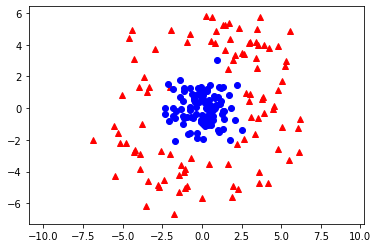

In [34]:

def  make_center_surround_data(examples_per_class, distance_from_origin):
  """create a 2-dimensional set of points, where half the points are drawn from
  one Gaussian centered on the origin and the other half form a ring around
  the first class 
  
  PARAMETERS
  ----------
  examples_per_class      An integer determining how much data we'll generate

  distance_from_origin    All points from one of the Gaussians will have their 
                          coordinates updated to have their distance from the
                          origin increased by this ammount. Should be 
                          non-negative.

  RETURNS
  -------
  data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows
  
  labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
            element. The jth element is the label of the jth example"""

  mean = [0,0]
  cov = [[1,0],[0,1]] 

  # negative class -1
  negData = np.random.multivariate_normal(mean,cov,examples_per_class)

  # positive class 1
  posData = np.random.multivariate_normal(mean,cov,examples_per_class) 
  
  # now....treat the positive class as having been drawn from phase, magnitude
  # coordinates and manipulate the magnitude so the mean distance of the points
  # from the origin is 4...and make sure the distribution of phase is all the way
  # way around the circle 
  magnitude = posData.T[0,:] + distance_from_origin 
  phase = posData.T[1,:]  * 2

  # now go back to cartesian coordinates
  x = magnitude * np.cos(phase)
  y = magnitude * np.sin(phase)

  # and stick it back in the array
  posData.T[0,:] = x
  posData.T[1,:] = y

  # wrap it up and return it.
  negL = np.ones(examples_per_class) * -1  
  posL = np.ones(examples_per_class)
  data = np.concatenate([posData, negData])
  labels = np.concatenate([posL,negL])

  return data, labels

# Test it out
data, labels = make_center_surround_data(100, 5)
plot_data(data, labels)


## Data Set 4: Spirals 

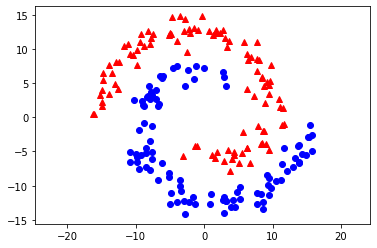

In [35]:
from numpy import pi
def  make_spiral_data(examples_per_class):
  """create a 2-dimensional set of points in two interwoven spirals. All elements
  in a single spiral share a label (either +1 or -1, depending on the spiral)
  
  PARAMETERS
  ----------
  examples_per_class      An integer determining how much data we'll generate

  RETURNS
  -------
  data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows
  
  labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
            element. The jth element is the label of the jth example"""

 
  theta = np.sqrt(np.random.rand(examples_per_class))*2*pi 

  # make points in a spiral that have some randomness
  r_a = 2*theta + pi
  temp = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  negData = temp + np.random.randn(examples_per_class,2)

  # make points in a spiral offset from the first one that have some randomness
  r_b = -2*theta - pi
  temp = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  posData = temp + np.random.randn(examples_per_class,2)

  # give labels to the data
  negL = np.ones(examples_per_class) * -1  
  posL = np.ones(examples_per_class)

  # return the data 
  data = np.concatenate([posData, negData])
  labels = np.concatenate([posL,negL])

  return data, labels

# Test it out
data, labels = make_spiral_data(100)
plot_data(data, labels)



# Build a perceptron 


In [36]:
def perceptron_fit(data, labels, weights, step_size=1, verbose = False):
  """ This implements a linear perceptron for two-way classification. A single
  layer perceptron is an algorithm for supervised learning of a binary
  classifier. The idea is to draw a hyperplane that separates the classes
  Points on one side of the hyperplane are one class and points on the other 
  side are the other class. Here's the pseudo code:

  begin initialize weights
     while not converged or not exceeded maxEpochs
          for each example in features
              if example is misclassified using weights
              then weights = weights + example * label_for_example * step_size
      return weights
  end
  
 
  PARAMETERS
  ----------
 
  data       A numpy array of real values with n rows and d columns, where n
             is the number of data points and d is the number of dimensions.
 
  labels     A vector containing labels drawn from {1,-1}. The jth label
             is the label of the jth example data point in data.

  weights    a vector of d+1 weights for a 1950's style perceptron, where d is 
             the number of dimensions of the data
  
  step_size  a positive real value in the range 0 < step_size <= 1

  verbose    If true, it will print out its calculations after every
             looking at each data point

  RETURNS
  -------
  converged  set to 1 if a line that separated the two classes was found. 
             Else it is set to 0.
  
  weights    a vector of d+1 weights that characterize the hyperplane that
             separates the data (if it convereged). If data has 3 dimensions, 
             then weights will have 4 elements. The first element is the 
             bias (aka offset), the remaining weights correspond to the weight
             associated with each of the 3 dimensions of the data.
  """
  # To do the perceptron algorithm, add a column of ones to the data, these
  # will correspond to the bias.
  num_points,num_dimensions = np.shape(data)
  b = np.ones(num_points)
  bias = np.expand_dims(b,axis=1)
  data_plus = np.append(bias,data,axis=1)

  converged = 1; # we're being optimistic.

  # iterate over ever element in the data
  for n in range(0,num_points):
      point = data_plus[n]
      label = labels[n]
      
      # this is where the perceptron classifies
      estimated_label = np.sign(np.sum(np.multiply(weights,point)))
     
      if verbose:
        print(' point = ', point, '  label = ', label, ' estimated_label = ', estimated_label)
        print('old weights = ', weights)
    
      # This is where the perceptron updates
      if (estimated_label != label):
        converged=0  # admit we haven't converged 
        weights = weights + (step_size * label * point) #change the weights of the hyperplane
        if verbose: print('new weights = ', weights)

  return converged, weights  



In [37]:
def perceptron_predict(data, weights):
  """ This predicts a label (+1 or -1) for each example in data, returning that
   as a numpy array.
 
  PARAMETERS
  ----------
 
  data       A numpy array of real values with n rows and d columns, where n
             is the number of data points and d is the number of dimensions.
             Each row is a data point to be classiified.
 
  weights    a vector of d+1 weights that characterize the hyperplane that
             separates the data. If data has 3 columns (aka dimensions), 
             then weights will have 4 elements. The first element is the 
             bias (aka offset), the remaining weights correspond to the weight
             associated with each of the 3 dimensions of the data.
  RETURNS
  -------
  prediction a vector with n values 
  """
  # To do the perceptron algorithm, add a column of ones to the data, these
  # will correspond to the bias.
  num_points,num_dimensions = np.shape(data)
  b = np.ones(num_points)
  bias = np.expand_dims(b,axis=1)
  data_plus = np.append(bias,data,axis=1)

  # now predict classes
  class_prediction = np.zeros(num_points)
  for n in range(0,num_points):
        point = data_plus[n]
        class_prediction[n] = np.sign(np.sum(np.multiply(weights,point)))

  return class_prediction

## Define a helper function to display the decision surface

 

In [38]:
def plot_decision_surface(use_model,model=None, perceptron_weights=0, axis_limits=[-5,5,-5,5]):
  """ Creates a grid of points, measures what a model would label each 
   point as, and uses this data to draw a region for class +1 and a region for
   class -1. Note...you could borrow this...
 
  PARAMETERS
  ----------
  use_model   If TRUE, a pytorch model is expected. If FALSE, weights are expected.

  model       A pytorch model that can take 2-d real vaued input and produce
              a +1 or -1 label for each data point. 

  weights     A vector of weights for separating hyperplane used in 
              perceptron_predict(). Note, we're expecting 3 weights here.

  axis_limits an array-like object with 4 floats [lowest_horizontal, highest_horizontal,
              lowest_vertical, highest_vertical]. This sets the limits over which
              the decision surface will be caluclated. 

  RETURNS
  -------
  my_contour  a matplotlib.contour.QuadContourSet with the contour
  """
  # Create a grid of points spanning the entire space displayed in the axis.
  # This will let us draw the decision boundary later

  xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                       np.arange(axis_limits[2], axis_limits[3], .05))
  data = np.concatenate([xx.reshape([1,-1]),yy.reshape([1,-1])]).T
  
  # Predict the class of each point in XGrid, using the classifier.
  # This shows our regions determined by the classifier
  if use_model == True:
    with torch.no_grad():
      pl = model(torch.tensor(data).to(dtype=torch.float32))
      predicted_labels = np.sign(pl.numpy())
  else:
    predicted_labels = perceptron_predict(data, perceptron_weights)
  
  predicted_labels = predicted_labels.reshape(xx.shape)
  
  # Put the result into a color plot
  plt.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
  plt.axis('equal')
  plt.axis('tight')


# Make some data and initialize the perceptron


In [ ]:
# Make the data  
examples_per_class = 5
distance_between_means = 2

data,labels = make_linearly_separable_data(examples_per_class, distance_between_means)
#data, labels = make_XOR_data(examples_per_class)
#data,labels = make_center_surround_data(examples_per_class, distance_between_means)

# set the weights of the perceptron to an inital set of random values
weights = np.random.rand(1,3)

# get some values I'll need for plotting the deciisiion surface.
data_min = np.min(np.min(data))
data_max = np.max(np.max(data))
num_points,num_dimensions = np.shape(data)

# initialize my count of where I am in training the data
epoch = 0
example = 0

# see what we're working with as a starting point
plot_data(data,labels)
plot_decision_surface(use_model=False, perceptron_weights=weights, axis_limits=[data_min-1, data_max+1, data_min-1, data_max+1])

# show us the first point we'll be reacting to
dumnmy = plt.text(data[example][0],data[example][1], 'first')

# Train the perceptron

In [ ]:
### display the data and the current decision surface
# train one ONE data point

converged, weights = perceptron_fit([data[example]], [labels[example]], weights, step_size=.2, verbose=True)
example += 1
example = example % num_points

# plot how things are now
plot_data(data,labels)
plot_decision_surface(use_model=False, perceptron_weights=weights, axis_limits=[data_min-1, data_max+1, data_min-1, data_max+1])

# show us the next point we'll be reacting to
dummy = plt.text(data[example][0],data[example][1], 'next')

Let's go faster and do an entire epoch at a time

In [41]:
## display the data and the current decision surface

#converged, weights = perceptron_fit(data, labels, weights)
#epoch += 1
#print('converged =', converged, ' epoch = ', epoch)
#plot_data(data,labels)
#plot_decision_surface(use_model=False, perceptron_weights=weights, axis_limits=[data_min-1, data_max+1, data_min-1, data_max+1])



# Now build a PyTorch model


## Define the model architecture and data flow 

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  """ Our first neural network model. We'll keep it simple.
  """
  # this bit determines the architecture of each layer...but not how data flows
  def __init__(self):
    super(Net, self).__init__() # has to be here
    self.fc1 = nn.Linear(2,25)
    self.fc2 = nn.Linear(25,2)
    self.fc3 = nn.Linear(2,1)
  # this part determines how data in x flows through the network. 
  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return x

##  A function to train the model

In [43]:

def train_model(model, data, target):
  """ A simple functon that runs the network model through one epoch of the 
  training data and then updates the weights to move moodel output closer to the
  target output. 
  
  PARAMETERS
  ----------
  model   a torch.nn.Model
  data      a 2-D torch tensor where data[i] contains the ith example.
  target    a torch tensor where target[i]  contains the expected output
            of the model in response to input data[i]
  """
  # This tells your model that you are in training mode. 
  # Layers (like dropout, batchnorm) that behave differently
  # when training than they do in testing can behave accordingly.   
  # It doesn't do much on this model, but you need to do this, as standard
  # practice
  model.train()

  # Set the gradients to 0 before running the net on the data
  # so that loss is calculated correctly.
  optimizer.zero_grad()

  # Get the output of the network on the data 
  output = model(data)

  # Measure the "loss" using mean squared error
  loss = F.mse_loss(output.squeeze(), target)
    
  # This calculates the gradients, running backward through the network
  loss.backward()

  # This updates the network weights 
  optimizer.step()


## A function to test the model

In [44]:

def test_model(model, data, target):
  """ A simple functon that prints out the model's loss and accuracy on the 
  data  
  
  PARAMETERS
  ----------
  model     a torch.nn.Model
  data      a 2-D torch tensor where data[i] contains the ith example.
  target    a torch tensor where target[i]  contains the expected output
            of the model in response to input data[i]
  RETURNS
  -------
  accuracy  The accuracy on the data
  
  loss      The loss on the data
  """
  # This puts the network in evaluation mode so things like dropout aren't done
  model.eval()

  # torch.nograd() tells the system to stop keeping track of gradients (derivatives)
  # when performing calculation. This makes things run faster. 
  with torch.no_grad():
    # get the output of the network on a batch of test examples
    output = model(data)
    output = output.squeeze()
    # measure loss 
    loss = F.mse_loss(output, target)
      
    # get the prediction of the network
    prediction = torch.sign(output)

    # measure the accuracy 
    c = prediction*target
    accuracy = torch.mean((c+1)/2)

    # lets report 
    #print('\nTest set: loss = ', round(loss.item(),4),
    #      ' accuracy = ', round(accuracy.item(),3), '\n')
    accuracy = round(accuracy.item(),3)
    loss = round(loss.item(),4)
    return accuracy, loss

## A function to print out the model structure

In [45]:
def print_model(model):
  """ A simple functon that prints out a torch model's structural details
  
  PARAMETERS
  ----------
  model     a torch.nn.Model
  """
  
  # Print model's state_dict
  print("Model's state_dict:")
  for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

  # Print the number of parameters in the model    
  parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(" my network has ", parameter_count, " trainable parameters")

  # Print optimizer's state_dict
  print("Optimizer's state_dict:")
  for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


# Make some data and train our PyTorch model!

## First, make and format the data for Torch

In [46]:
# Make the data  
examples_per_class = 20
distance_between_means = 0

data,label = make_linearly_separable_data(examples_per_class, distance_between_means)
#data, label = make_XOR_data(examples_per_class)
#data, label = make_spiral_data(examples_per_class)
#data,label = make_center_surround_data(examples_per_class, distance_between_means)

# The data is in 64bit numpy format. Reformat the data for TensorFlow
dataT = torch.tensor(data).to(dtype=torch.float32)
labelT = torch.tensor(label).to(dtype=torch.float32)

 

## Now, make and initialize the torch model we're going to train

In [ ]:
# make the model
modelo = Net()
optimizer = optim.SGD(modelo.parameters(), lr=0.01,momentum=0.9)
print_model(modelo)


## Look at the model's decision surface, before training

In [ ]:
scale = 2
# look at the decision surface and model decision surface
plot_data(dataT,labelT)
xmin,xmax,ymin,ymax=plt.axis()
plot_decision_surface(use_model=True, model=modelo, axis_limits=[xmin*scale,xmax*scale,ymin*scale,ymax*scale])

# measure model accuracy
accuracy, loss = test_model(modelo, dataT, labelT)
print('accuracy=' + str(accuracy)+ ' loss=' + str(loss))


## Train  and look at the result

In [ ]:
epochs = 1000
scale = 1
for i in range(0,epochs):
  train_model(modelo,dataT,labelT)

plot_data(dataT,labelT)
xmin,xmax,ymin,ymax = plt.axis()
plot_decision_surface(use_model=True, model=modelo, axis_limits=[xmin*scale,xmax*scale,ymin*scale,ymax*scale])
accuracy, loss = test_model(modelo, dataT, labelT)
print('accuracy=' + str(accuracy)+ ' loss=' + str(loss))
